# Praca domowa nr 3
### Wojciech Celej

---

## 1. Odtworzenie danych

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Przygotowanie danych

Wybrane przeze mnie zmienne to:
* ilościowe: 
    - `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    - `w6_q24_length` - length of q24 how met answer in characters 
* jakościowe: 
    - `hcm2017q24_church` - met in or through church or religious organization
    - `hcm2017q24_btwn_I_sig_other` - significant other relationship  between intermediaries

In [3]:
features = ["time_from_rel_to_cohab", "w6_q24_length", "hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", "S1"]

In [4]:
myDf = df.loc[:, features].dropna()
myDf = myDf.query("time_from_rel_to_cohab > 0")

In [5]:
myDf.loc[:,"hcm2017q24_church"] = myDf.loc[:,"hcm2017q24_church"].map({"yes": 1, "no": 0})
myDf.loc[:,"hcm2017q24_btwn_I_sig_other"] = myDf.loc[:,"hcm2017q24_btwn_I_sig_other"].map({"yes": 1, "no": 0})
myDf.loc[:,"S1"] = myDf.loc[:,"S1"].apply(lambda x: 1 if x.startswith("Yes") else 0).astype(np.int32)

In [6]:
myDf.describe()

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other,S1
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,2.062339,200.837784,0.063417,0.015531,0.768335
std,2.775628,253.214722,0.243764,0.123677,0.421987
min,0.083252,1.000000,0.000000,0.000000,0.000000
25%,0.500000,67.000000,0.000000,0.000000,1.000000
50%,1.166748,136.000000,0.000000,0.000000,1.000000
75%,2.583252,241.000000,0.000000,0.000000,1.000000
max,36.750000,3855.000000,1.000000,1.000000,1.000000


### Klasyfikator: XGBoost

In [7]:
import xgboost
import sklearn.model_selection
import sklearn.metrics

In [8]:
xgbModel = xgboost.XGBClassifier(max_depth=3)
X = myDf.iloc[:, :4]
Y = myDf.loc[:, "S1"]
cv_scores = sklearn.model_selection.cross_validate(xgbModel, X, Y, cv = 10)

In [9]:
xgbModel.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
cv_scores["test_score"].mean()

0.7627211831629472

---

## 2. Wykres Break Down dla 2 scenariuszy

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(9,12)})
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.1)

Wylosowana obserwacja (z ziarnem 123):

In [16]:
sample = X.sample(n=1, random_state=123).reset_index(drop=True)
sample

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other
0,2.166626,33.0,0,0


In [17]:
def plot_break_down(model, df, sample, features_path, ax):
    modDf = df.copy()
    y = model.predict_proba(modDf)[:,1]
    resultDf = pd.DataFrame(data = {"marriedProb": y, "step": "all data"})
    for feature in features_path:
        value_of_feature = sample.loc[0, feature]
        modDf[feature] = value_of_feature
        y = model.predict_proba(modDf)[:,1] 
        resultDf = resultDf.append(pd.DataFrame(data = {"marriedProb": y, "step": "+ {} = {:0.2f}".format(feature, value_of_feature)}), ignore_index=True)
    steps = resultDf["step"].unique()[::-1]
    sns.violinplot(data = resultDf,  x="marriedProb", y="step", inner=None, order=steps, ax=ax, color = "white")
    means = []
    for i, step in enumerate(steps):
        mean = resultDf.loc[resultDf["step"]==step].loc[:, "marriedProb"].mean()
        ax.plot(mean, i, "o", color="firebrick", markersize=10)
        ax.text(mean + 0.025, i - 0.15, "{:0.3f}".format(mean))
        means.append(mean)
    for i in range(len(steps)-2, -1, -1):
        diff = means[i]-means[i+1]
        color = "darkgreen" if diff >= 0 else "darkred"
        ax.text(1.05, i, "{:+0.3f}".format(diff), color = color)
    ax.grid(axis="y")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xlim(0, 1)

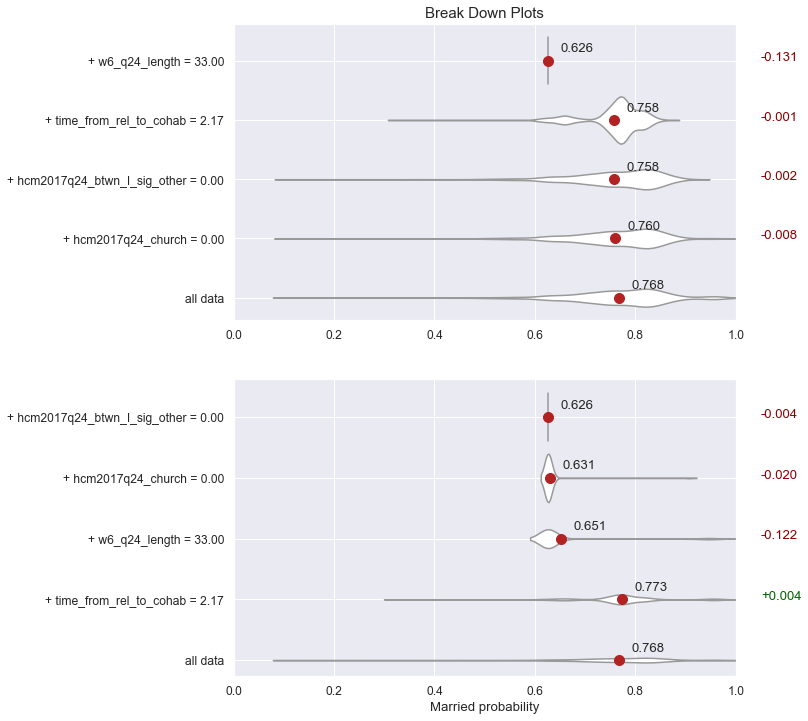

In [18]:
fig, axes = plt.subplots(2, 1)
order1 = ["hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", "time_from_rel_to_cohab", "w6_q24_length"]
order2 = ["time_from_rel_to_cohab", "w6_q24_length", "hcm2017q24_church", "hcm2017q24_btwn_I_sig_other"]

plot_break_down(xgbModel, X, sample, order1, axes[0])
plot_break_down(xgbModel, X, sample, order2, axes[1])

axes[0].set_title("Break Down Plots", fontsize = 15)
axes[1].set_xlabel("Married probability")
plt.show()

Znaczenie zmiennych:
* ilościowych:
    * `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    * `w6_q24_length` - length of q24 how met answer in characters
* jakościowych (w obu przypadkach binarnych):
    * `hcm2017q24_church` - met in or through church or religious organization
    * `hcm2017q24_btwn_I_sig_other` - significant other relationship  between intermediaries

Kolejność zmiennych ustalono następująco:
1. scenariusz - najpierw dodano wpływ zmiennych jakościowcyh, a później ilościowcyh
2. scenariusz -  najpierw dodano wpływ zmiennych ilościowych, a później jakościowych

---

## 3. Wnioski

* W obu scenariuszach, dla badanej obserwacji, największy i zarazem ujemny wpływ na predykcję modelu wywarła zmienna `w6_q24_length`
* Druga w kolejności jest zmienna jakościowa `hcm2017q24_church` - jej wpływ również jest ujemny i ponad 2x większy niż w 2. scenariuszu
* Zmienna `time_from_rel_to_cohab` ma wpływ dodatni w 2. scenariuszu, ale ujemny w 1. scenariuszu, w obu scenariuszach niewielki
* Zmiana kolejności zmiennych ma wpływ na obserwowane wyniki predykcji w poszczegłonych krokach (interakcja między zmiennymi)